# Initial settings

In [2]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

#Libraries
import yaml
import math
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import datasets as datasets_torch
from torchvision.transforms import (
    Compose,
    Resize,
    CenterCrop,
    RandomHorizontalFlip,
    ToTensor,
    Normalize,
    InterpolationMode,
)
import wandb
import datasets, diffusers
from datasets import load_dataset
from diffusers import UNet2DModel, DDPMScheduler
from diffusers import DDPMPipeline
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version
import logging
from accelerate.logging import get_logger
from accelerate import Accelerator

import torchvision
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from PIL import Image
import csv
import cv2 as cv

# MAIN

In [3]:
selected_gpu = 0 #select the GPU to use
device = torch.device("cuda:" + str(selected_gpu) if torch.cuda.is_available() else "cpu")
print(f'The device is: {device}\n')

# load the config file
with open('config_playground.yaml') as file: # expects the config file to be in the same directory
    config = yaml.load(file, Loader=yaml.FullLoader)
    
# define logging directory
pipeline_dir = repo_path / config['saving']['local']['outputs_dir'] / config['saving']['local']['pipeline_name']
logging_dir = pipeline_dir / config['logging']['dir_name']

# start the accelerator
accelerator = Accelerator(
    gradient_accumulation_steps=config['training']['gradient_accumulation']['steps'],
    mixed_precision=config['training']['mixed_precision']['type'],
    log_with= config['logging']['logger_name'],
    logging_dir= logging_dir,
)

# show the accelerator state as first log message
print(accelerator.state)

# define data directory
data_dir = repo_path / config['processing']['dataset']

The device is: cuda:0

Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda
Mixed precision type: no



## Get maximum values among all images

## Load data with custom dataset

In [113]:
# create a dataset class for our breast images
class breast_dataset(torch.utils.data.Dataset):
    def __init__(self, csv_path: Path, images_dir: Path, transform=None):
        """_summary_

        Args:
            csv_path (Path): path to the csv file with the filenames
            images_dir (Path): path to the folder with the images
            transform (function, optional): transformation function. Usually pytorch.Transform. Defaults to None.
        """
        self.names = pd.read_csv(csv_path, header=None) # read csv file
        self.images_dir = images_dir # path to image folder
        self.transform = transform # transform to apply to images
    
    def __len__(self):
        """returns the length of the dataset

        Returns:
            int: length of the dataset
        """
        return len(self.names)
    
    def __getitem__(self, idx: int):
        """returns the image at index idx

        Args:
            idx (int): index in the csv file

        Returns:
            PIL.Image: PIL image
        """
        img_path = self.images_dir / self.names.iloc[idx, 0] # get image path
        image = Image.open(img_path) # open image
        # image = np.array(image, dtype=np.float32) # convert to numpy array
        if self.transform: # apply transform if it exists
            image = self.transform(image)
            
        return image
    
    def set_transform(self, transform):
        """set the transform to apply to the images

        Args:
            transform (function): transform to apply to the images
        """
        self.transform = transform

    def __repr__(self) -> str:
        return f"({len(self)} images)"

def load_breast_dataset(folder_dir:Path):
    # get directory name
    folder_name = folder_dir.name
    # check if the csv file with the filenames already exists
    csv_path = folder_dir.parent.parent / 'filenames' / f'{folder_name}.csv'
    if not csv_path.exists(): # if not, create it
        with open(csv_path, mode='w', newline='') as file:
            writer = csv.writer(file)
            for filename in os.listdir(folder_dir):
                if filename.endswith(".png"):
                    writer.writerow([filename])
    # now we can create the dataset
    dataset = breast_dataset(csv_path, images_dir= folder_dir)
    
    return dataset    

class ToFloat32Tensor(object):
    """
    Converts a PIL Image to a PyTorch tensor with dtype float32, and normalises it.
    """
    def __call__(self, image):
        # Convert PIL Image to PyTorch tensor with dtype float32
        tensor = ToTensor()(image).float()/config['processing']['normalisation_value']
        return tensor

In [139]:
dataset_mine = load_breast_dataset(data_dir)

preprocess = Compose(
    [
        Resize(config['processing']['resolution'], interpolation= InterpolationMode.BILINEAR), #resize image to square keeping aspect ratio
        CenterCrop(config['processing']['resolution']), # crop image to the center
        ToFloat32Tensor(), # convert to tensor with float16 dtype
        Normalize(mean=[0.5], std=[0.5]), # normalise to [-1,1] (mean and std of the dataset
    ]
)
# set transform
dataset_mine.set_transform(preprocess)

# Create the dataloader
train_dataloader = torch.utils.data.DataLoader(
    dataset_mine, batch_size=config['processing']['batch_size'], num_workers= 0, shuffle=True
)

# get an example batch
xb = next(iter(train_dataloader))

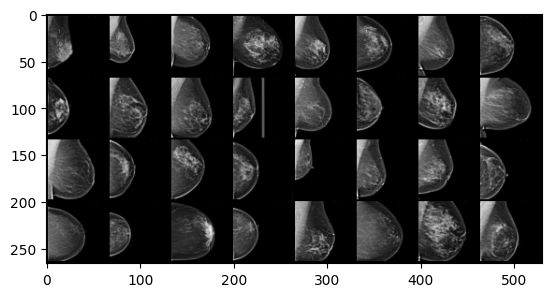

In [140]:
x = xb
grid = torchvision.utils.make_grid(x,normalize=True)
grid_im = grid.detach().cpu().permute(1,2,0).numpy()
plt.imshow(grid_im, cmap='gray')

In [10]:
gray_example = xb[0,0]
# max value
print(f'Max value: {gray_example.max()}')

Max value: 6813.83154296875


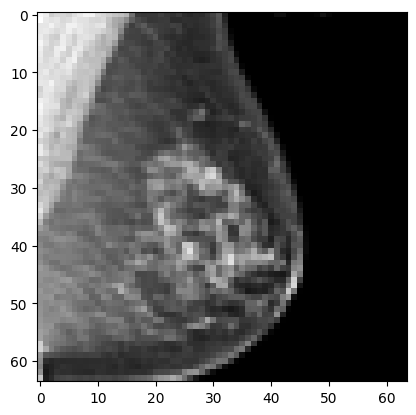

In [34]:
example = xb[0,0].cpu().numpy()
# plot the example
import matplotlib.pyplot as plt
plt.imshow(example, cmap='gray')

## Load model

In [4]:
from huggingface_hub import get_full_repo_name
from diffusers import DDPMPipeline

# Let's give our new model a name for the Hub
model_name = "Breast_unconditional_64"
hub_model_id = get_full_repo_name(model_name)

pipeline = DDPMPipeline.from_pretrained(hub_model_id).to(device)
images = pipeline(batch_size=1).images

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

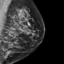

In [6]:
images[0]

In [7]:
# HP
image_size = 64

# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)
# model
model = pipeline.unet

# Random starting point (8 random images):
sample = torch.randn(8, 1, image_size, image_size).to(device)

for i, t in enumerate(tqdm(noise_scheduler.timesteps)):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample


100%|██████████| 1000/1000 [00:38<00:00, 25.90it/s]
